# Soil water-holding capacity

European soil database derived data - total available water content (TAWC)
for the topsoil [mm] (European Commission, n.d.; Hiederer, 2013a;
Hiederer, 2013b):
https://esdac.jrc.ec.europa.eu/content/european-soil-database-derived-data

In [22]:
import os
from zipfile import BadZipFile, ZipFile
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
from rasterstats import zonal_stats

In [23]:
DATA_DIR = os.path.join(
    "data", "soil", "european-soil-database-derived-data"
)

In [24]:
ZIP_FILE = os.path.join(DATA_DIR, "STU_EU_Layers.zip")

In [25]:
# list of files/folders in the ZIP archive
ZipFile(ZIP_FILE).namelist()

['SMU_EU_S_TAWC.RDC',
 'SMU_EU_S_TAWC.rst',
 'SMU_EU_T_TAWC.RDC',
 'SMU_EU_T_TAWC.rst',
 'STU_EU_ALLOCATION.RDC',
 'STU_EU_ALLOCATION.rst',
 'STU_EU_DEPTH_ROOTS.RDC',
 'STU_EU_DEPTH_ROOTS.rst',
 'STU_EU_S_BD.RDC',
 'STU_EU_S_BD.rst',
 'STU_EU_S_CLAY.RDC',
 'STU_EU_S_CLAY.rst',
 'STU_EU_S_GRAVEL.RDC',
 'STU_EU_S_GRAVEL.rst',
 'STU_EU_S_OC.RDC',
 'STU_EU_S_OC.rst',
 'STU_EU_S_SAND.RDC',
 'STU_EU_S_SAND.rst',
 'STU_EU_S_SILT.RDC',
 'STU_EU_S_SILT.rst',
 'STU_EU_S_TAWC.RDC',
 'STU_EU_S_TAWC.rst',
 'STU_EU_S_TEXT_CLS.RDC',
 'STU_EU_S_TEXT_CLS.rst',
 'STU_EU_T_BD.RDC',
 'STU_EU_T_BD.rst',
 'STU_EU_T_CLAY.RDC',
 'STU_EU_T_CLAY.rst',
 'STU_EU_T_GRAVEL.RDC',
 'STU_EU_T_GRAVEL.rst',
 'STU_EU_T_OC.RDC',
 'STU_EU_T_OC.rst',
 'STU_EU_T_SAND.RDC',
 'STU_EU_T_SAND.rst',
 'STU_EU_T_SILT.RDC',
 'STU_EU_T_SILT.rst',
 'STU_EU_T_TAWC.RDC',
 'STU_EU_T_TAWC.rst',
 'STU_EU_T_TEXT_CLS.RDC',
 'STU_EU_T_TEXT_CLS.rst']

In [26]:
# extract the archive
try:
    z = ZipFile(ZIP_FILE)
    z.extractall(DATA_DIR)
except BadZipFile:
    print("There were issues with the file", ZIP_FILE)

In [27]:
DATA_FILE = os.path.join(DATA_DIR, "STU_EU_T_TAWC.rst")

In [28]:
data = rxr.open_rasterio(DATA_FILE, chunks="auto", masked=True)

In [29]:
data

<xarray.DataArray (band: 1, y: 4600, x: 5900)>
dask.array<open_rasterio-fe4b1480115aa1d61925a510437a7116<this-array>, shape=(1, 4600, 5900), dtype=float32, chunksize=(1, 4600, 5900), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.5e+06 1.502e+06 1.502e+06 ... 7.398e+06 7.4e+06
  * y            (y) float64 5.5e+06 5.498e+06 5.498e+06 ... 9.015e+05 9.005e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    units:         milimeter

In [30]:
data.rio.crs

CRS.from_wkt('LOCAL_CS["Unknown",UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [31]:
# manually assign CRS: ETRS 89 LAEA
data_crs = 3035

In [32]:
data.rio.write_crs(data_crs, inplace=True)

<xarray.DataArray (band: 1, y: 4600, x: 5900)>
dask.array<open_rasterio-fe4b1480115aa1d61925a510437a7116<this-array>, shape=(1, 4600, 5900), dtype=float32, chunksize=(1, 4600, 5900), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.5e+06 1.502e+06 1.502e+06 ... 7.398e+06 7.4e+06
  * y            (y) float64 5.5e+06 5.498e+06 5.498e+06 ... 9.015e+05 9.005e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    units:         milimeter

In [33]:
data.rio.crs

CRS.from_epsg(3035)

In [34]:
data.rio.resolution()

(1000.0, -1000.0)

In [35]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries.gpkg")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")

In [36]:
ie.crs

<Derived Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [37]:
# clip raster to Ireland's boundary
data = rxr.open_rasterio(
    DATA_FILE, chunks="auto", masked=True
).rio.clip(ie.buffer(6500).to_crs(data_crs))

In [38]:
data

<xarray.DataArray (band: 1, y: 409, x: 418)>
dask.array<getitem, shape=(1, 409, 418), dtype=float32, chunksize=(1, 409, 418), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.918e+06 2.92e+06 2.92e+06 ... 3.334e+06 3.336e+06
  * y            (y) float64 3.728e+06 3.728e+06 ... 3.322e+06 3.32e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    units:         milimeter

In [39]:
data.max().values

array(117.38613, dtype=float32)

In [40]:
data.min().values

array(0., dtype=float32)

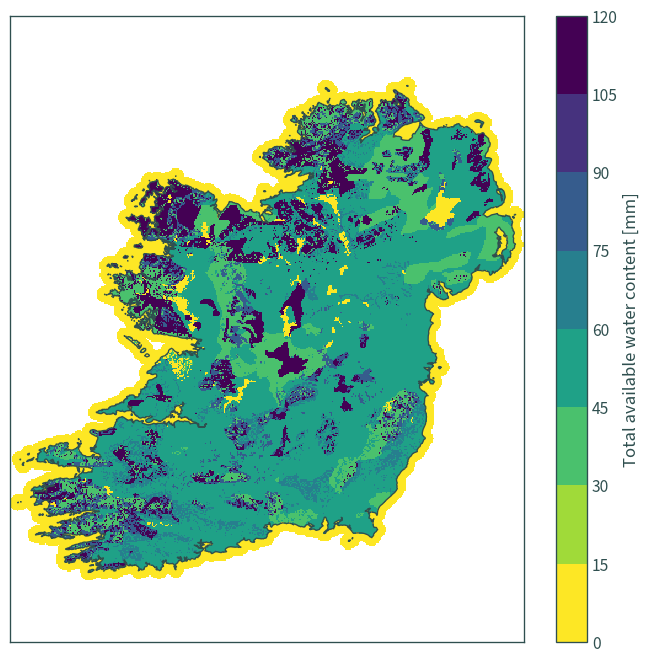

In [41]:
fig = data.plot(
    robust=True, cmap="viridis_r", figsize=(7, 7), levels=10,
    cbar_kwargs={"label": "Total available water content [mm]"}
)
ie.to_crs(data_crs).boundary.plot(
    ax=fig.axes, color="darkslategrey", linewidth=1
)
plt.title(None)
fig.axes.tick_params(labelbottom=False, labelleft=False)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.axis("equal")
plt.show()

In [42]:
# export to GeoTIFF
data.rio.to_raster(os.path.join(DATA_DIR, "IE_TAWC.tif"))

## Grid cells

In [43]:
grid_cells = gpd.read_file(
    os.path.join("data", "ModVege", "params.gpkg"), layer="eurocordex"
)

In [44]:
grid_cells.head()

,rlon,rlat,sr,ni,geometry
0,-17.265,4.345,0.763591,0.35,"POLYGON ((419870.326 550490.053, 415715.725 56..."
1,-17.265,4.455,0.000000,0.35,"POLYGON ((415715.725 562009.784, 411561.600 57..."
2,-17.265,4.565,0.000000,0.35,"POLYGON ((411561.600 573530.159, 407407.964 58..."
3,-17.265,4.675,0.000000,0.35,"POLYGON ((407407.964 585051.187, 403254.829 59..."
4,-17.265,4.785,0.000000,0.35,"POLYGON ((403254.829 596572.878, 399102.207 60..."


In [45]:
grid_cells.crs

<Derived Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [46]:
grid_cells.shape

(765, 5)

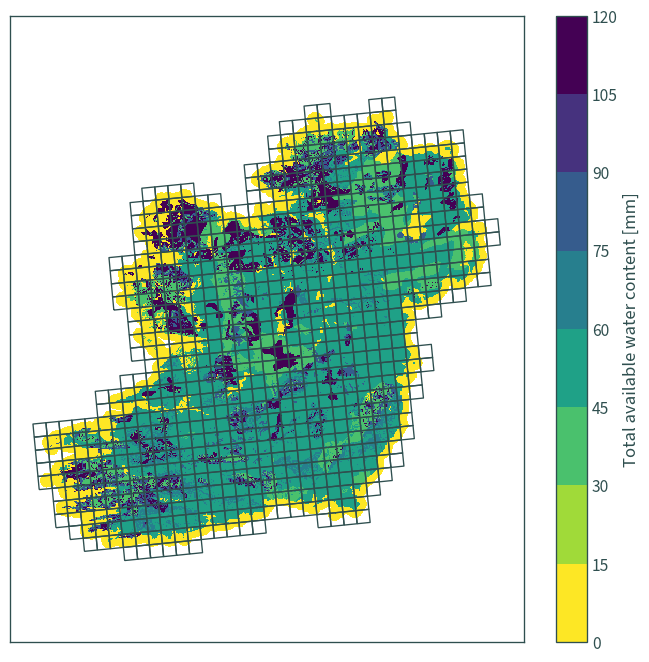

In [47]:
fig = data.plot(
    robust=True, cmap="viridis_r", figsize=(7, 7), levels=10,
    cbar_kwargs={"label": "Total available water content [mm]"}
)
grid_cells.to_crs(data_crs).boundary.plot(
    ax=fig.axes, color="darkslategrey", linewidth=1
)
plt.title(None)
fig.axes.tick_params(labelbottom=False, labelleft=False)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.axis("equal")
plt.show()

## Zonal stats

In [48]:
grid_cells = gpd.GeoDataFrame.from_features(
    zonal_stats(
        vectors=grid_cells.to_crs(data_crs),
        raster=os.path.join(DATA_DIR, "IE_TAWC.tif"),
        stats=["count", "mean"],
        geojson_out=True,
        nodata=-999999
    ), crs=data_crs
).to_crs(grid_cells.crs)

In [49]:
grid_cells.head()

,geometry,rlon,rlat,sr,ni,mean,count
0,"POLYGON ((419870.326 550490.053, 415715.725 56...",-17.265,4.345,0.763591,0.35,0.0,119
1,"POLYGON ((415715.725 562009.784, 411561.600 57...",-17.265,4.455,0.000000,0.35,0.0,45
2,"POLYGON ((411561.600 573530.159, 407407.964 58...",-17.265,4.565,0.000000,0.35,0.0,54
3,"POLYGON ((407407.964 585051.187, 403254.829 59...",-17.265,4.675,0.000000,0.35,0.0,116
4,"POLYGON ((403254.829 596572.878, 399102.207 60...",-17.265,4.785,0.000000,0.35,0.0,67


In [50]:
grid_cells.shape

(765, 7)

In [51]:
grid_cells["mean"].min()

0.0

In [52]:
grid_cells["mean"].max()

114.76114198825503

In [53]:
grid_cells["count"].min()

0

In [54]:
grid_cells["count"].max()

154

In [55]:
grid_cells[grid_cells["count"] == 0]

,geometry,rlon,rlat,sr,ni,mean,count
99,"POLYGON ((474491.495 687204.081, 470328.825 69...",-16.385,5.335,0.0,0.35,NaN,0
458,"POLYGON ((556849.412 925216.933, 552662.092 93...",-14.955,7.095,0.0,0.35,NaN,0
611,"POLYGON ((734722.641 651078.195, 730526.414 66...",-14.295,4.235,0.0,0.35,NaN,0
731,"POLYGON ((753193.890 814183.944, 748979.265 82...",-13.635,5.555,0.0,0.35,NaN,0


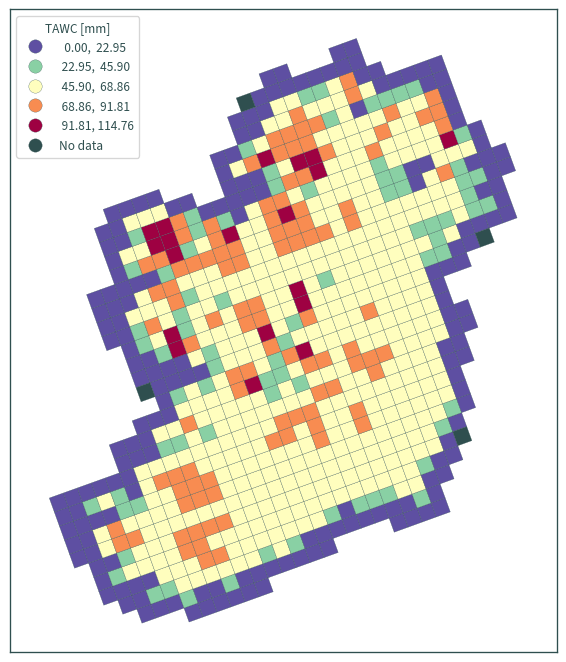

In [56]:
axs = grid_cells.plot(
    column="mean", cmap="Spectral_r", scheme="equal_interval",
    edgecolor="darkslategrey", linewidth=.2, figsize=(6, 7),
    legend=True, legend_kwds={
        "loc": "upper left", "fmt": "{:.2f}", "title": "WHC [mm]"
    },
    missing_kwds={
        "color": "darkslategrey", "edgecolor": "darkslategrey",
        "label": "No data"
    }
)
for legend_handle in axs.get_legend().legendHandles:
    legend_handle.set_markeredgewidth(.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [60]:
# fill no data with min value
grid_cells["mean"] = grid_cells["mean"].fillna(grid_cells["mean"].min())

In [61]:
grid_cells["whc"] = grid_cells["mean"]

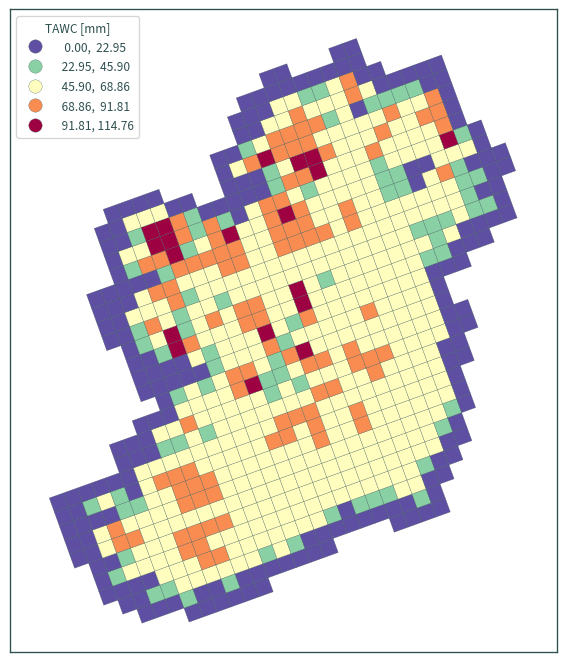

In [62]:
axs = grid_cells.plot(
    column="mean", cmap="Spectral_r", scheme="equal_interval",
    edgecolor="darkslategrey", linewidth=.2, figsize=(6, 7),
    legend=True, legend_kwds={
        "loc": "upper left", "fmt": "{:.2f}", "title": "WHC [mm]"
    },
    missing_kwds={
        "color": "darkslategrey", "edgecolor": "darkslategrey",
        "label": "No data"
    }
)
for legend_handle in axs.get_legend().legendHandles:
    legend_handle.set_markeredgewidth(.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [63]:
grid_cells.drop(columns=["mean", "count"], inplace=True)

In [64]:
grid_cells.head()

,geometry,rlon,rlat,sr,ni,whc
0,"POLYGON ((419870.326 550490.053, 415715.725 56...",-17.265,4.345,0.763591,0.35,0.0
1,"POLYGON ((415715.725 562009.784, 411561.600 57...",-17.265,4.455,0.000000,0.35,0.0
2,"POLYGON ((411561.600 573530.159, 407407.964 58...",-17.265,4.565,0.000000,0.35,0.0
3,"POLYGON ((407407.964 585051.187, 403254.829 59...",-17.265,4.675,0.000000,0.35,0.0
4,"POLYGON ((403254.829 596572.878, 399102.207 60...",-17.265,4.785,0.000000,0.35,0.0


In [65]:
grid_cells.to_file(
    os.path.join("data", "ModVege", "params.gpkg"), layer="eurocordex"
)